# Gaussian Process Fitting

by Sarah Blunt

### Prerequisites
This tutorial assumes knowledge of the basic `radvel` API for $\chi^2$ likelihood fitting. As such, please complete the following before beginning this tutorial:
- radvel/docs/tutorials/164922_Fitting+MCMC.ipynb
- radvel/docs/tutorials/K2-24_Fitting+MCMC.ipynb

This tutorial also assumes knowledge of Gaussian Processes (GPs) as applied to radial velocity (RV) timeseries modeling. Grunblatt et al. (2015) and Rajpaul et al. (2015) contain excellent introductions to this topic. Also check out "Gaussian Processes for Machine Learning," by Rasmussen & Williams, a free online textbook hosted at gaussianprocesses.org.

### Objectives
Using the K2-131 (EPIC-228732031) dataset published in Dai et al. (2017), I will show how to:
- perform a maximum a posteriori (MAP) fit using a quasi-periodic kernel GP regression to model stellar activity (with data from multiple telescopes)
- do an MCMC exploration of the corresponding parameter space (with data from multiple telescopes)

### Tutorial


Do some preliminary imports:

In [1]:
import numpy as np
import pandas as pd
import os
import radvel
from radvel.plot import orbit_plots, mcmc_plots
from scipy import optimize

%matplotlib inline

/Users/bjfulton/anaconda3/lib/python3.6/site-packages/emcee-2.2.1-py3.6.egg/emcee/ptsampler.py:36: DeprecationWarning: invalid escape sequence \e
/Users/bjfulton/anaconda3/lib/python3.6/site-packages/astropy/extern/bundled/six.py:60: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/bjfulton/anaconda3/lib/python3.6/site-packages/astropy/extern/bundled/six.py' mode='r' encoding='utf-8'>
  class X(object):
/Users/bjfulton/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/bjfulton/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/bjfulton/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args,

Read in RV data from Dai et al. (2017):

In [2]:
data = pd.read_csv(os.path.join(radvel.DATADIR,'k2-131.txt'), sep=' ')

t = np.array(data.time)
vel = np.array(data.mnvel)
errvel = np.array(data.errvel)
tel = np.array(data.tel)

telgrps = data.groupby('tel').groups
instnames = telgrps.keys()

We'll use a quasi-periodic covariance kernel in this fit. An element in the covariance matrix, $C_{ij}$ is defined as follows:

$$
C_{ij} = \eta_1^2 exp[-\frac{|t_i-t_j|^2}{\eta_2^2} -\frac{sin^2(\pi|t_i-t_j|/\eta_3)}{2\eta_4^2}] 
$$



Several other kernels are implemented in `radvel`. The code for all kernels lives in radvel/gp.py. Check out that file if you'd like to implement a new kernel.

Side Note: to see a list of all implemented kernels and examples of possible names for their associated hyperparameters...

In [3]:
print(radvel.gp.KERNELS)

{'SqExp': ['gp_length', 'gp_amp'], 'Per': ['gp_per', 'gp_length', 'gp_amp'], 'QuasiPer': ['gp_per', 'gp_perlength', 'gp_explength', 'gp_amp'], 'Celerite': ['1_logA', '1_logB', '1_logC', '1_logD']}


Define the GP hyperparameters we will use in our fit:

In [4]:
hnames = [
    'gp_amp', # eta_1; GP variability amplitude
    'gp_explength', # eta_2; GP non-periodic characteristic length
    'gp_per', # eta_3; GP variability period
    'gp_perlength', # eta_4; GP periodic characteristic length
]

Define some numbers (derived from photometry) that we will use in our priors on the GP hyperparameters:

In [5]:
gp_explength_mean = 9.5*np.sqrt(2.) # sqrt(2)*tau in Dai+ 2017 [days]
gp_explength_unc = 1.0*np.sqrt(2.)
gp_perlength_mean = np.sqrt(1./(2.*3.32)) # sqrt(1/(2*gamma)) in Dai+ 2017
gp_perlength_unc = 0.019
gp_per_mean = 9.64 # T_bar in Dai+ 2017 [days]
gp_per_unc = 0.12

Porb = 0.3693038 # orbital period [days]
Porb_unc = 0.0000091 
Tc = 2457582.9360 # [BJD]
Tc_unc = 0.0011

Dai et al. (2017) derive the above from photometry (see sect 7.2.1). I'm currently working on implementing joint modeling of RVs & photometry and RVs & activity indicators in `radvel`, so stay tuned if you'd like to use those features!

Initialize `radvel.Parameters` object:

In [6]:
nplanets=1
params = radvel.Parameters(nplanets,basis='per tc secosw sesinw k')

Set initial guesses for each fitting parameter:

In [7]:
params['per1'] = radvel.Parameter(value=Porb)
params['tc1'] = radvel.Parameter(value=Tc)
params['sesinw1'] = radvel.Parameter(value=0.,vary=False) # fix eccentricity = 0
params['secosw1'] = radvel.Parameter(value=0.,vary=False)
params['k1'] = radvel.Parameter(value=6.55)
params['dvdt'] = radvel.Parameter(value=0.,vary=False)
params['curv'] = radvel.Parameter(value=0.,vary=False)

Set initial guesses for GP hyperparameters:

In [8]:
params['gp_amp'] = radvel.Parameter(value=25.0)
params['gp_explength'] = radvel.Parameter(value=gp_explength_mean) 
params['gp_per'] = radvel.Parameter(value=gp_per_mean) 
params['gp_perlength'] = radvel.Parameter(value=gp_perlength_mean)

Instantiate a `radvel.model.RVmodel` object, with `radvel.Parameters` object as attribute:

In [9]:
gpmodel = radvel.model.RVModel(params)

Initialize `radvel.likelihood.GPLikelihood` objects (one for each telescope):

In [10]:
jit_guesses = {'harps-n':0.5, 'pfs':5.0}

likes = []
def initialize(tel_suffix):

    # Instantiate a separate likelihood object for each instrument.
    # Each likelihood must use the same radvel.RVModel object.
    indices = telgrps[tel_suffix]
    like = radvel.likelihood.GPLikelihood(gpmodel, t[indices], vel[indices], 
                                          errvel[indices], hnames, suffix='_'+tel_suffix, 
                                          kernel_name="QuasiPer"
                                          )
    # Add in instrument parameters
    like.params['gamma_'+tel_suffix] = radvel.Parameter(value=np.mean(vel[indices]))
    like.params['jit_'+tel_suffix] = radvel.Parameter(value=jit_guesses[tel_suffix]) 
    likes.append(like)


for tel in instnames:
    initialize(tel)

Instantiate a `radvel.likelihood.CompositeLikelihood` object that has both GP likelihoods as attributes:

In [11]:
gplike = radvel.likelihood.CompositeLikelihood(likes)

Instantiate a `radvel.Posterior` object:

In [12]:
gppost = radvel.posterior.Posterior(gplike)

Add in priors (see Dai et al. 2017 section 7.2):

In [13]:
gppost.priors += [radvel.prior.Gaussian('per1', Porb, Porb_unc)]
gppost.priors += [radvel.prior.Gaussian('tc1', Tc, Tc_unc)]
gppost.priors += [radvel.prior.Jeffreys('k1', 0.01, 10.)] # min and max for Jeffrey's priors estimated by Sarah
gppost.priors += [radvel.prior.Jeffreys('gp_amp', 0.01, 100.)]
gppost.priors += [radvel.prior.Jeffreys('jit_pfs', 0.01, 10.)]
gppost.priors += [radvel.prior.Jeffreys('jit_harps-n', 0.01,10.)]
gppost.priors += [radvel.prior.Gaussian('gp_explength', gp_explength_mean, gp_explength_unc)]
gppost.priors += [radvel.prior.Gaussian('gp_per', gp_per_mean, gp_per_unc)]
gppost.priors += [radvel.prior.Gaussian('gp_perlength', gp_perlength_mean, gp_perlength_unc)]

Note: our prior on `'gp_perlength'` isn't equivalent to the one Dai et al. (2017) use because our formulations of the quasi-periodic kernel are slightly different. The results aren't really affected.

Do a MAP fit:

In [14]:
res = optimize.minimize(
    gppost.neglogprob_array, gppost.get_vary_params(), method='Powell',
    options=dict(maxiter=200, maxfev=100000, xatol=1e-8)
)

print(gppost)

/Users/bjfulton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: OptimizeWarning: Unknown solver options: xatol
  This is separate from the ipykernel package so we can avoid doing imports until


parameter                     value      vary
per1                       0.369302       True
tc1                         7582.94       True
secosw1                           0      False
sesinw1                           0      False
k1                          6.74824       True
dvdt                              0      False
curv                              0      False
gp_amp                      23.0453       True
gp_explength                13.3689       True
gp_per                       9.6254       True
gp_perlength               0.381483       True
gamma_harps-n              -6694.18       True
jit_harps-n                    0.01       True
gamma_pfs                  -7.27619       True
jit_pfs                      4.4742       True

Priors
------
Gaussian prior on per1, mu=0.3693038, sigma=9.1e-06
Gaussian prior on tc1, mu=2457582.936, sigma=0.0011
Jeffrey's prior on k1, min=0.01, max=10.0
Jeffrey's prior on gp_amp, min=0.01, max=100.0
Jeffrey's prior on jit_pfs, min=0.01, max

Explore the parameter space with MCMC:

In [15]:
chains, minTz, maxGR = radvel.mcmc(gppost,nrun=100,ensembles=3)

15000/15000 (100.0%) steps complete; Running 3681.45 steps/s; Mean acceptance rate = 39.6%; Min Tz = 54.7; Max G-R = 1.060      

MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.


Note: for reliable results, run MCMC until the chains have converged. For this example, nrun=10000 should do the trick, but that would take a minute or two, and I won't presume to take up that much of your time with this tutorial.

Make some nice plots:

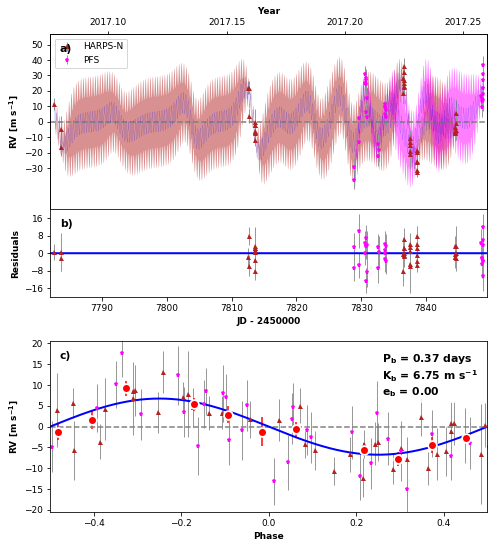

In [16]:
# try switching some of these (optional) keywords to "True" to see what they do!
GPPlot = orbit_plots.GPMultipanelPlot(
    gppost,
    subtract_gp_mean_model=False,
    plot_likelihoods_separately=False, 
    subtract_orbit_model=False
) 
GPPlot.plot_multipanel()

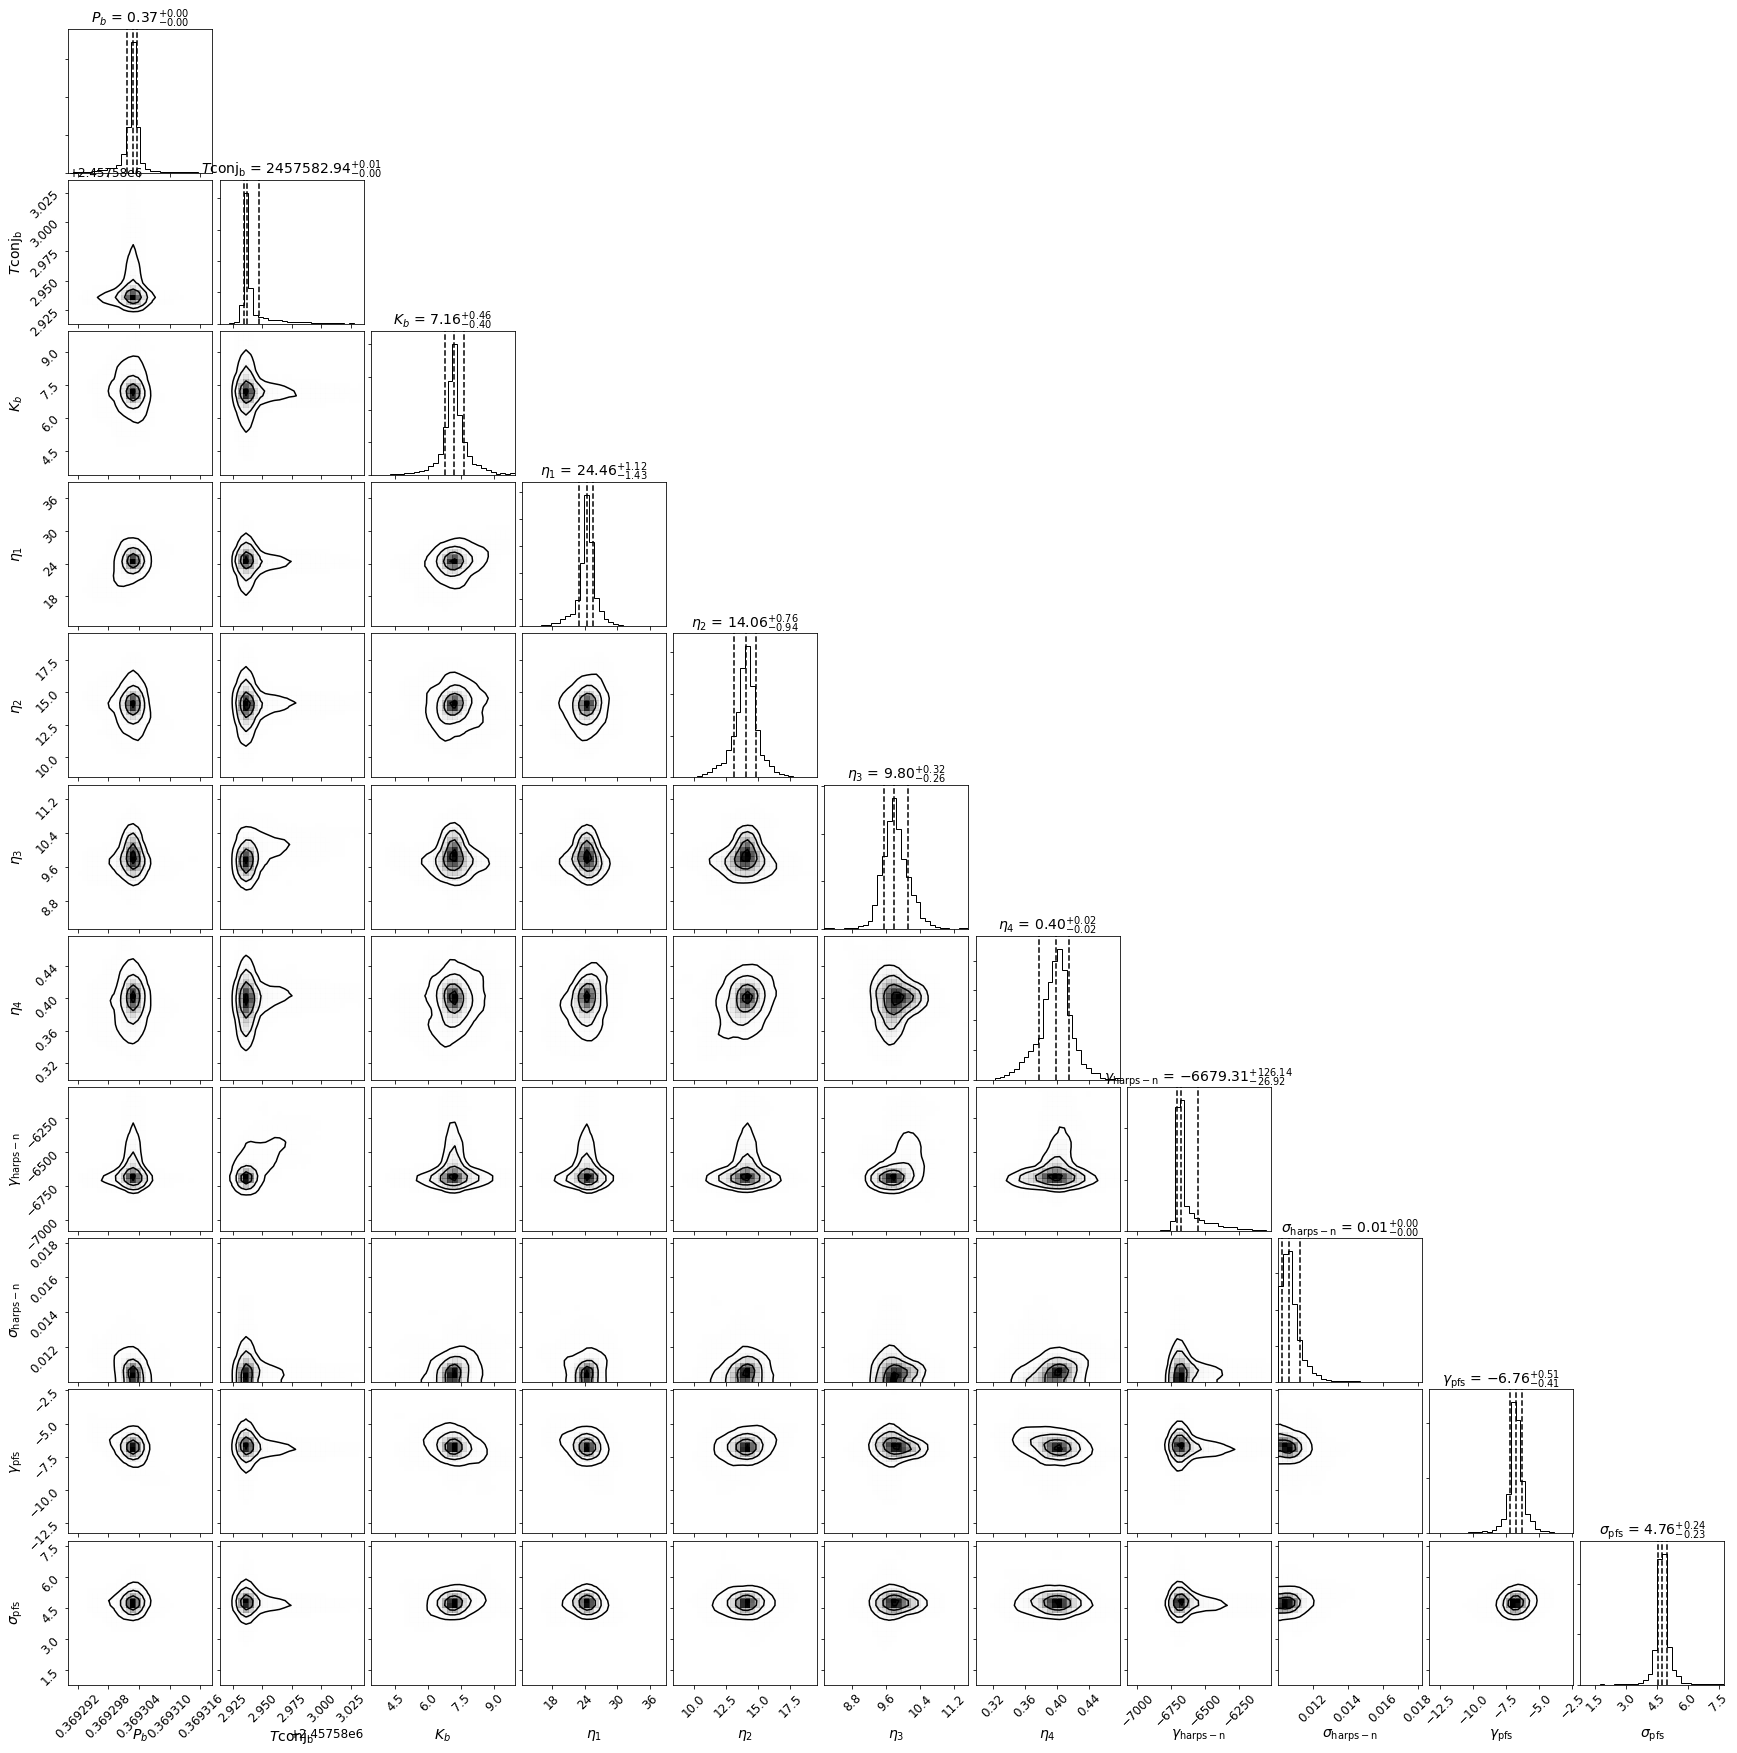

In [17]:
Corner = mcmc_plots.CornerPlot(gppost, chains) # posterior distributions
Corner.plot()

In [18]:
quants = chains.quantile([0.159, 0.5, 0.841]) # median & 1sigma limits of posterior distributions

for par in gppost.params.keys():
    if gppost.params[par].vary:
        med = quants[par][0.5]
        high = quants[par][0.841] - med
        low = med - quants[par][0.159]
        err = np.mean([high,low])
        err = radvel.utils.round_sig(err)
        med, err, errhigh = radvel.utils.sigfig(med, err)
        print('{} : {} +/- {}'.format(par, med, err))

per1 : 0.369303 +/- 1e-06
tc1 : 2457582.9369 +/- 0.0065
k1 : 7.16 +/- 0.44
gp_amp : 24.5 +/- 1.3
gp_explength : 14.06 +/- 0.85
gp_per : 9.8 +/- 0.29
gp_perlength : 0.399 +/- 0.019
gamma_harps-n : -6679 +/- 77
jit_harps-n : 0.01063 +/- 0.00049
gamma_pfs : -6.76 +/- 0.46
jit_pfs : 4.76 +/- 0.24


Compare posterior characteristics with those of Dai et al. (2017):

per1 : 0.3693038 +/- 9.1e-06

tc1 : 2457582.936 +/- 0.0011

k1 : 6.6 +/- 1.5

gp_amp : 26.0 +/- 6.2

gp_explength : 11.6 +/- 2.3

gp_per : 9.68 +/- 0.15

gp_perlength : 0.35 +/- 0.02

gamma_harps-n : -6695 +/- 11

jit_harps-n : 2.0 +/- 1.5

gamma_pfs : -1 +/- 11

jit_pfs : 5.3 +/- 1.4

Thanks for going through this tutorial! As always, if you have any questions, feature requests, or problems, please file an issue on the `radvel` GitHub repo (github.com/California-Planet-Search/radvel). 